# Gaussian Mixture Model for IPOC data - 2nd try

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
from sklearn import mixture
from sklearn import preprocessing
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import feature_extraction as fe
from anomaly_detection import GMM
from anomaly_detection import PCA
#from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

In [2]:
client = mongo_client.CERNMongoClient()
for e in client.get_all_collections():
    if 'IPOC.AB1' in e:
        print(e)
        
df = client.query_resample("^.*IPOC.AB1.*")
#display(df.describe)
display(df.describe())

MKI.UA23.IPOC.AB1:T_LENGTH
MKI.UA23.IPOC.AB1:E_KICK
MKI.UA23.IPOC.AB1:T_FALLTIME
MKI.UA23.IPOC.AB1:T_START_TH
MKI.UA23.IPOC.AB1:T_RISETIME
MKI.UA23.IPOC.AB1:I_STRENGTH
MKI.UA23.IPOC.AB1:T_DELAY
Fetching data for pattern ^.*IPOC.AB1.*
Fetching data for MKI.UA23.IPOC.AB1:T_LENGTH
Fetching data for MKI.UA23.IPOC.AB1:E_KICK
Fetching data for MKI.UA23.IPOC.AB1:T_FALLTIME
Fetching data for MKI.UA23.IPOC.AB1:T_START_TH
Fetching data for MKI.UA23.IPOC.AB1:T_RISETIME
Fetching data for MKI.UA23.IPOC.AB1:I_STRENGTH
Fetching data for MKI.UA23.IPOC.AB1:T_DELAY


series  MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:E_KICK  \
count                 30541.000000              30541.000000   
mean                      4.472024               3942.731438   
std                      13.961999               2972.620797   
min                       0.000000                400.200000   
25%                       2.079200                450.000000   
50%                       2.081700               4187.400000   
75%                       3.478100               6499.440000   
max                     139.429700               7864.200000   

series  MKI.UA23.IPOC.AB1:T_FALLTIME  MKI.UA23.IPOC.AB1:T_START_TH  \
count                   30541.000000                  30541.000000   
mean                        1.381353                     52.584384   
std                         2.346255                      8.159589   
min                      -125.350100                    -13.831000   
25%                         1.389600                     52.287000   
50%                         1.393100                     52.289000   
75%                         1.398300                     52.292000   
max                       125.457900                     62.789000   

series  MKI.UA23.IPOC.AB1:T_RISETIME  MKI.UA23.IPOC.AB1:I_STRENGTH  \
count                   30541.000000                  30541.000000   
mean                        0.650794                      4.558481   
std                         0.184367                      0.796574   
min                       -13.608500                     -0.000600   
25%                         0.657300                      4.507900   
50%                         0.657700                      4.809400   
75%                         0.660600                      5.068400   
max                        13.687100                      5.193100   

series  MKI.UA23.IPOC.AB1:T_DELAY  
count                30541.000000  
mean                    53.235178  
std                      8.226227  
min                    -13.815400  
25%                     52.945100  
50%                     52.947600  
75%                     52.951000  
max                     63.455000

Better not use up/down-sampling for IPOC data, as there's no fixed frequency and hence updsampling produces incorrect samples. Query_resample function modified to support sample_size=None

## Below some faulty-acquisition filtering
crude filtering, based on expert advise: correct *IPOC* values only when I_STRENGTH>1kV AND T_DELAY>10us

In [19]:
dff1 = df[(df['MKI.UA23.IPOC.AB1:I_STRENGTH']>1)]
dff = dff1[dff1['MKI.UA23.IPOC.AB1:T_DELAY']>10]
display(dff.describe())
display('Values filtered: %d' % (len(df.index.values) - len(dff.index.values)))

series  MKI.UA23.IPOC.AB1:T_LENGTH  MKI.UA23.IPOC.AB1:E_KICK  \
count                 30133.000000              30133.000000   
mean                      2.996763               3938.844697   
std                       1.607483               2961.247069   
min                       1.959200                400.200000   
25%                       2.079100                450.000000   
50%                       2.081600               4187.400000   
75%                       3.477700               6499.440000   
max                       9.355800               7864.200000   

series  MKI.UA23.IPOC.AB1:T_FALLTIME  MKI.UA23.IPOC.AB1:T_START_TH  \
count                   30133.000000                  30133.000000   
mean                        1.395636                     53.464855   
std                         0.010706                      3.042170   
min                         1.378300                     41.288000   
25%                         1.389800                     52.287000   
50%                         1.393200                     52.289000   
75%                         1.398400                     52.292000   
max                         1.504100                     62.789000   

series  MKI.UA23.IPOC.AB1:T_RISETIME  MKI.UA23.IPOC.AB1:I_STRENGTH  \
count                   30133.000000                  30133.000000   
mean                        0.659064                      4.585779   
std                         0.002436                      0.713795   
min                         0.656300                      1.450600   
25%                         0.657300                      4.540800   
50%                         0.657800                      4.810000   
75%                         0.660600                      5.069200   
max                         0.667000                      5.193100   

series  MKI.UA23.IPOC.AB1:T_DELAY  
count                30133.000000  
mean                    54.123920  
std                      3.043116  
min                     41.953900  
25%                     52.945200  
50%                     52.947600  
75%                     52.951100  
max                     63.455000

'Values filtered: 408'

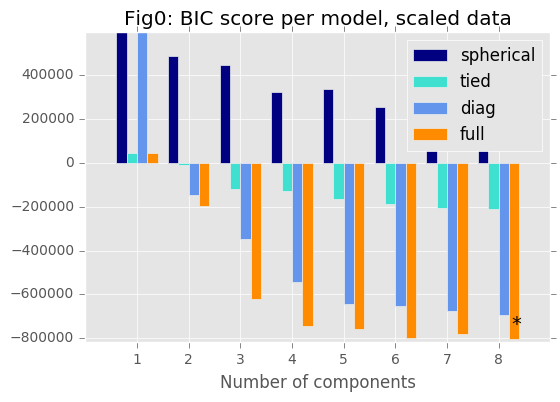

In [20]:
# normalize data and perform GMM component selection
dfn = preprocessing.scale(dff.values)
GMM.component_selection(dfn, 'Fig0: BIC score per model, scaled data',8)

In [21]:
# GMM fit (100% of data), components manually selected from plot above
# trying full-6 and spherical-4
clf = mixture.GaussianMixture(n_components=4, covariance_type='spherical')
clf.fit(dfn)

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=4, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

Log probs shape: 30133


'Log probs mean: -6.03841273564'

'Log probs min: -92.9012986986'

'Log probs max: 0.681936845444'

1pct percentile: -18


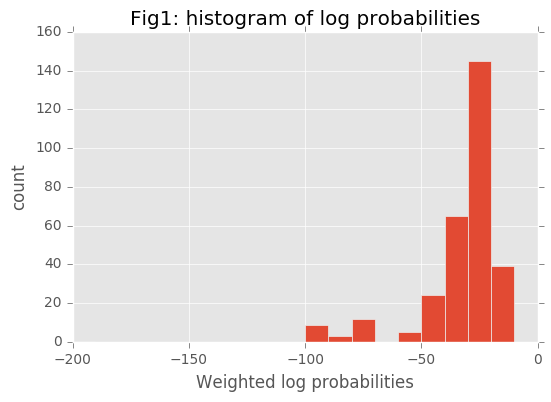

In [22]:
# Compute the weighted log probabilities for each sample, 1-dim ndarray is returned 
# testing set = training set !
log_probs = clf.score_samples(dfn)
print("Log probs shape: %s" % log_probs.shape)
display("Log probs mean: %s" % log_probs.mean())
display("Log probs min: %s" % log_probs.min())
display("Log probs max: %s" % log_probs.max())
pct = np.percentile(log_probs, 1)
print("1pct percentile: %d" % pct)
# np.where returns an array with the element positions where the condition is true
idx = np.where((log_probs < pct))
anomaly_log_probs = log_probs[idx]
binwidth = 10
plt.figure()
plt.hist(anomaly_log_probs, bins=np.arange(-200, max(anomaly_log_probs) + binwidth, binwidth));
plt.title("Fig1: histogram of log probabilities")
plt.xlabel('Weighted log probabilities')
plt.ylabel('count')

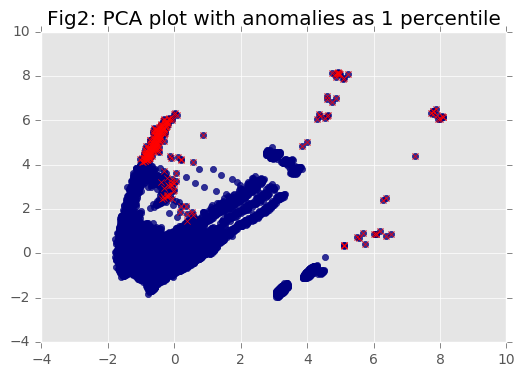

In [23]:
pca = PCA.create_pca(n_components=2)
pca_data = PCA.transform_data(dfn, pca)
PCA.plot_anomalies(pca_data, idx[0], "Fig2: PCA plot with anomalies as 1 percentile")

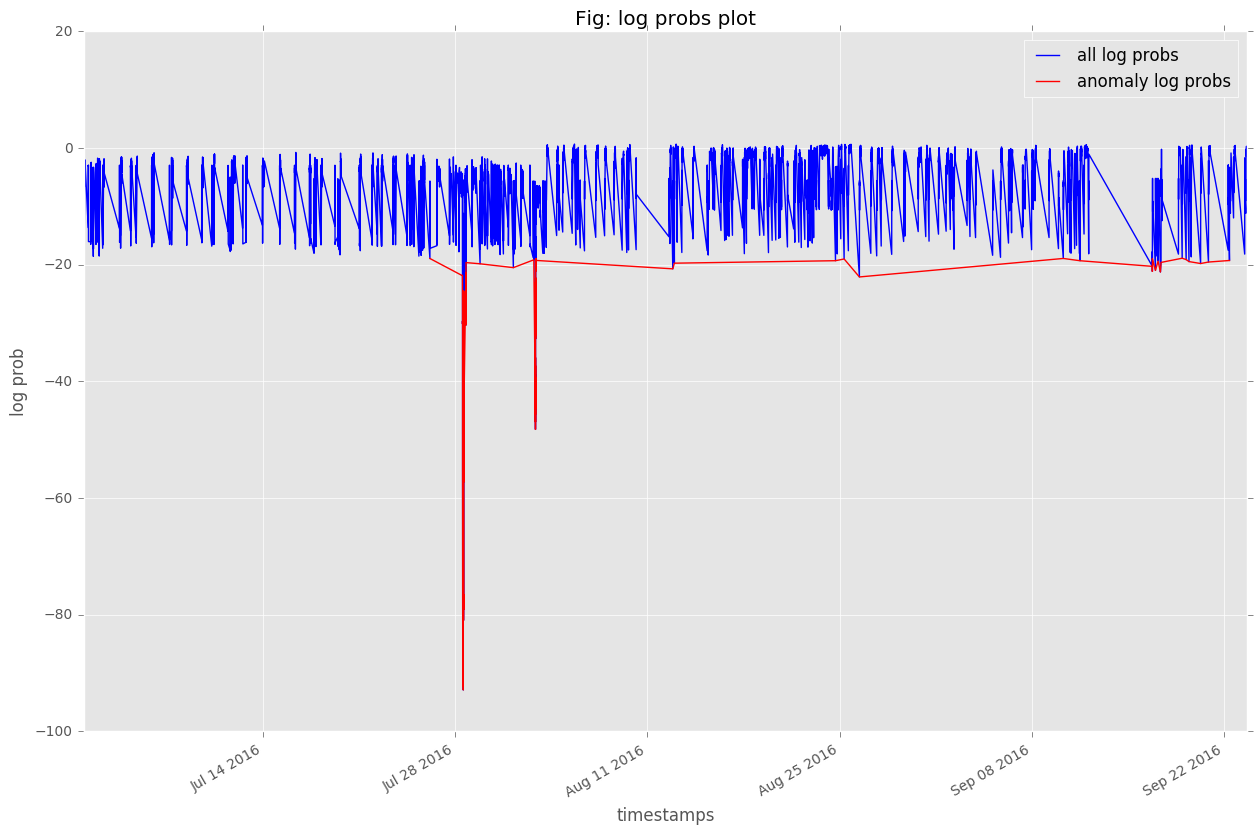

In [24]:
# try to plot it
log_probs_df = pd.DataFrame(data=log_probs, index=dff.index)
anomaly_log_probs_df = log_probs_df.iloc[idx[0].tolist()]


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,10))
log_probs_df.plot(ax=axes, color='b')
anomaly_log_probs_df.plot(ax=axes, color='r')
labels = ["all log probs", "anomaly log probs"]
axes.legend(labels)
axes.set_ylabel("log prob")
axes.set_title("Fig: log probs plot")

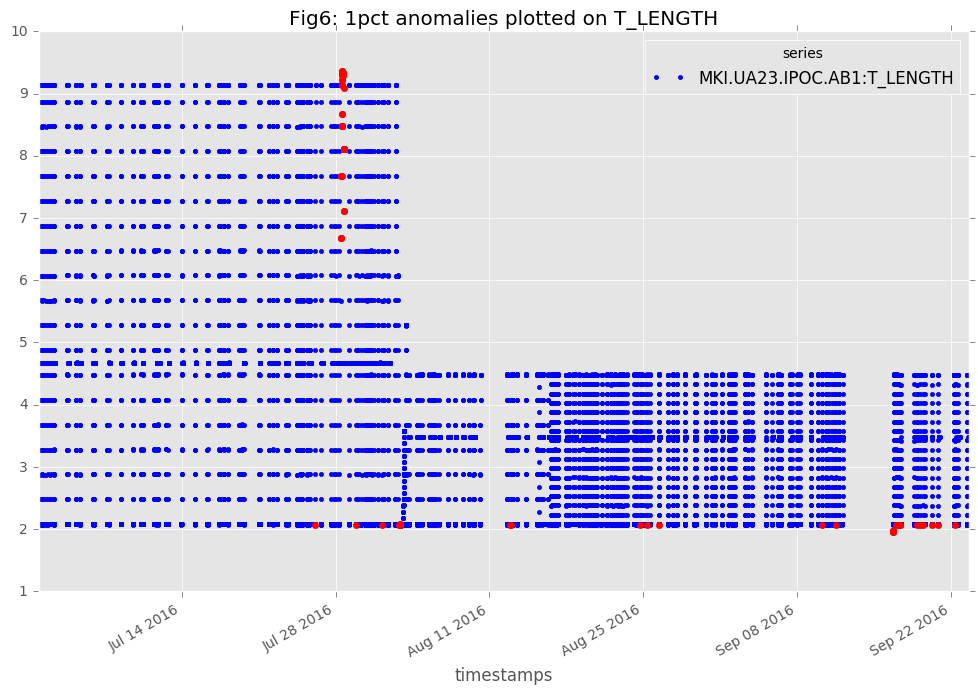

In [25]:
results.plot_anomalies_timeseries(dff, idx[0], "T_LENGTH", "Fig6: 1pct anomalies plotted on T_LENGTH", 'none', '.')

array(['2016-07-28T15:11:13.887000000+0200',
       '2016-07-28T15:12:35.487000000+0200',
       '2016-07-28T15:13:57.087000000+0200',
       '2016-07-28T15:26:11.487000000+0200',
       '2016-07-28T15:28:54.687000000+0200',
       '2016-07-28T15:30:16.287000000+0200',
       '2016-07-28T15:55:25.886000000+0200',
       '2016-07-28T16:00:11.487000000+0200',
       '2016-07-28T16:01:33.087000000+0200',
       '2016-07-28T16:08:06.687000000+0200',
       '2016-07-28T16:10:54.687000000+0200'], dtype='datetime64[ns]')

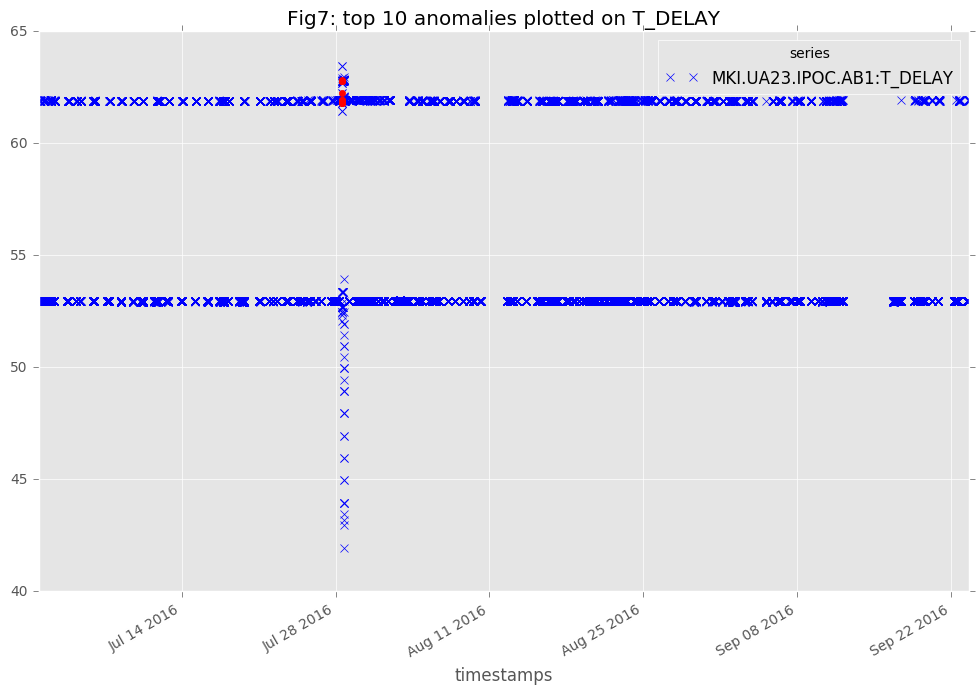

In [26]:
limit = 10
idx2 = np.argpartition(log_probs, limit) #first 20 elements will be the indexes of smallest elements
idx2 = idx2[:limit+1]
anomaly_tstamps = dff.index[idx2].sort_values()
display(anomaly_tstamps.values)
results.plot_anomalies_timeseries(dff, idx2, "T_DELAY", "Fig7: top 10 anomalies plotted on T_DELAY", 'none', 'x')

## Trying to add e-logbook entries to the same plot..

In [27]:
logdf = client.query_resample("MKI.ELOGBOOK", None, "$gte", "16-04-23 06:00:00.000000")
# display cannot handle dict values?
#display(logdf.describe())
#print(logdf[logdf.columns[0]].values[0]['SUBSTR_COMMENT_512_'])
print("df shape: %s" % (logdf.shape,))
# filtering after data start-date 2016-07-01
logentries = logdf[logdf.columns[0]].ix['2016-07-01':].index.values
#results.plot_anomalies_timeseries(dff, logentries, "T_LENGTH", "Fig8: Logbook entries plotted on T_LENGTH", 'none', 'x')
display(idx2, logentries)

Fetching data for pattern MKI.ELOGBOOK
Fetching data for MKI.ELOGBOOK
df shape: (104, 1)


array([8125, 8115, 8116, 8124, 8122, 8119, 8120, 8117, 8123, 8118, 8121])

array(['2016-07-03T11:00:00.000000000+0200',
       '2016-07-03T11:15:00.000000000+0200',
       '2016-07-05T15:41:00.000000000+0200',
       '2016-07-05T15:44:00.000000000+0200',
       '2016-07-14T11:23:00.000000000+0200',
       '2016-07-14T15:21:00.000000000+0200',
       '2016-07-14T15:25:00.000000000+0200',
       '2016-07-19T10:29:45.000000000+0200',
       '2016-07-19T17:14:52.000000000+0200',
       '2016-07-19T20:37:26.000000000+0200',
       '2016-07-20T08:30:00.000000000+0200',
       '2016-07-20T08:32:00.000000000+0200',
       '2016-07-20T10:24:00.000000000+0200',
       '2016-07-21T15:30:00.000000000+0200',
       '2016-07-22T08:16:00.000000000+0200',
       '2016-07-21T15:41:00.000000000+0200',
       '2016-07-21T19:50:00.000000000+0200',
       '2016-07-22T11:26:00.000000000+0200',
       '2016-07-25T00:19:48.000000000+0200',
       '2016-07-25T15:02:00.000000000+0200',
       '2016-07-28T15:04:31.000000000+0200',
       '2016-07-26T12:00:00.000000000+0200',
       '20